In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

2022-12-13 13:11:52.704936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 13:11:52.868228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 13:11:52.868284: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-13 13:11:52.904371: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-13 13:11:55.680179: W tensorflow/stream_executor/pla

In [ ]:
def normalize(col_data):
    return (col_data - col_data.min())/(col_data.max()-col_data.min())

In [ ]:
raw_data = pd.read_csv('../Data/Sequencing/sequenced_data.csv')

In [ ]:
dataset = raw_data.copy()

In [ ]:
X = dataset[['Yield(uM)','Yield(ug/ml)','Calculated MW(kDa)','Calculated pI', 'Sequence length', 'Sequence mass']]
y = dataset.iloc[:, 1:2]

In [ ]:
for column in X:
    X[column] = normalize(X[column])
X = round(X,2)

/tmp/ipykernel_278/3188529497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = normalize(X[column])


In [ ]:
y = round(normalize(y),2)

In [ ]:
sample_set = X.copy()
sample_set['Solubility(%)'] = y['Solubility(%)']


sample_set = sample_set[ ['Solubility(%)'] + [ col for col in sample_set.columns if col != 'Solubility(%)' ] ]

In [ ]:
train_dataset = sample_set.sample(frac=0.8, random_state=0)
test_dataset = sample_set.drop(train_dataset.index)

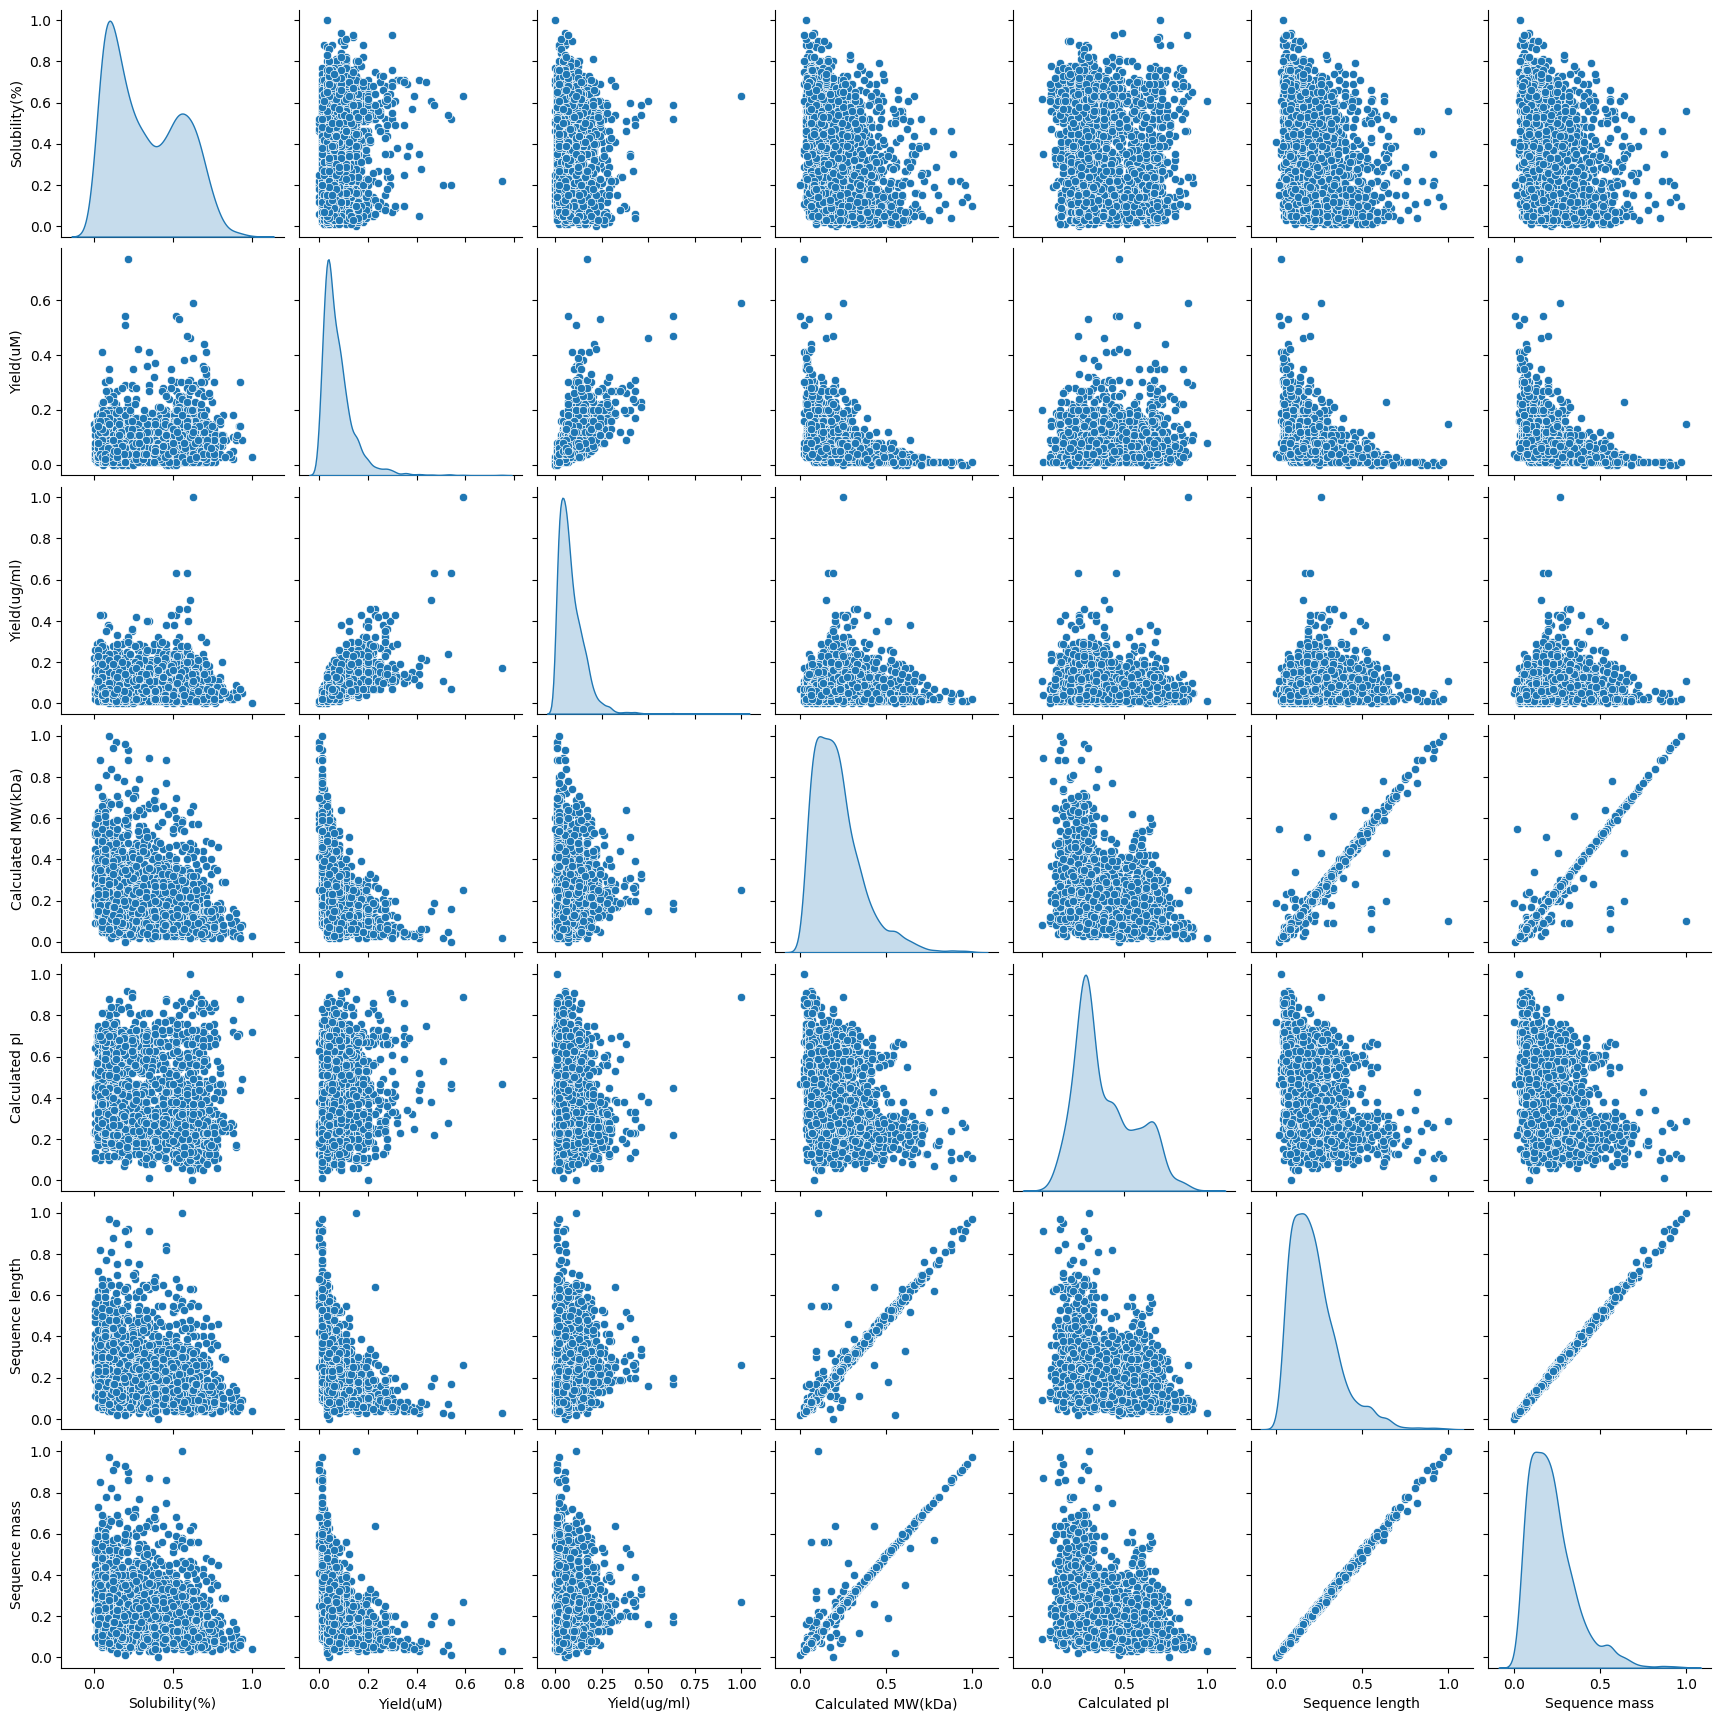

In [ ]:
sns.pairplot(train_dataset[train_dataset.columns], diag_kind='kde')

In [ ]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Solubility(%),2566.0,0.330203,0.226515,0.0,0.12,0.290,0.53,1.00
Yield(uM),2566.0,0.076368,0.067033,0.0,0.03,0.060,0.10,0.75
Yield(ug/ml),2566.0,0.084513,0.070386,0.0,0.04,0.070,0.12,1.00
Calculated MW(kDa),2566.0,0.217720,0.144416,0.0,0.11,0.190,0.28,1.00
Calculated pI,2566.0,0.381648,0.181627,0.0,0.25,0.320,0.51,1.00
Sequence length,2566.0,0.223788,0.139784,0.0,0.12,0.195,0.29,1.00
Sequence mass,2566.0,0.224209,0.139863,0.0,0.12,0.200,0.29,1.00


In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Solubility(%)')
test_labels = test_features.pop('Solubility(%)')

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Solubility(%),0.330203,0.226515
Yield(uM),0.076368,0.067033
Yield(ug/ml),0.084513,0.070386
Calculated MW(kDa),0.217720,0.144416
Calculated pI,0.381648,0.181627
Sequence length,0.223788,0.139784
Sequence mass,0.224209,0.139863


In [ ]:
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(train_features)

2022-12-13 13:12:13.087577: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-13 13:12:13.087615: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-13 13:12:13.087643: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-8ea8948f-b978-492f-a6dd-8ac5feb4b472): /proc/driver/nvidia/version does not exist
2022-12-13 13:12:13.087884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 7         
                                                                 
Total params: 20
Trainable params: 7
Non-trainable params: 13
_________________________________________________________________


In [ ]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 83ms/step


array([[-0.303],
       [-0.209],
       [-0.446],
       [ 0.084],
       [ 0.576],
       [ 0.445],
       [-0.156],
       [-0.376],
       [ 3.281],
       [ 0.83 ]], dtype=float32)

In [ ]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error',
    metrics=[tf.keras.metrics.MeanSquaredError(name='MSE'), tf.keras.metrics.RootMeanSquaredError(name='MRSE')])

In [ ]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/100
/shared-libs/python3.9/py/lib/python3.9/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
65/65 [==============================] - 1s 5ms/step - loss: 0.2595 - MSE: 0.1553 - MRSE: 0.3941 - val_loss: 0.2490 - val_MSE: 0.1123 - val_MRSE: 0.3351
Epoch 2/100
65/65 [==============================] - 0s 3ms/step - loss: 0.2011 - MSE: 0.0649 - MRSE: 0.2548 - val_loss: 0.1819 - val_MSE: 0.0506 - val_MRSE: 0.2249
Epoch 3/100
65/65 [==============================] - 0s 2ms/step - loss: 0.1855 - MSE: 0.0536 - MRSE: 0.2316 - val_loss: 0.1864 - val_MSE: 0.0544 - val_MRSE: 0.2333
Epoch 4/100
65/65 [==============================] - 0s 2ms/step - loss: 0.1900 - MSE: 0.057

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,MSE,MRSE,val_loss,val_MSE,val_MRSE,epoch
95,0.209722,0.071332,0.267081,0.195158,0.059528,0.243983,95
96,0.194352,0.058876,0.242644,0.226130,0.085420,0.292267,96
97,0.184449,0.051629,0.227219,0.177520,0.048305,0.219785,97
98,0.187497,0.053371,0.231023,0.213611,0.069182,0.263025,98
99,0.202477,0.064173,0.253325,0.173758,0.044464,0.210864,99


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [Solubility]')
  plt.legend()
  plt.grid(True)


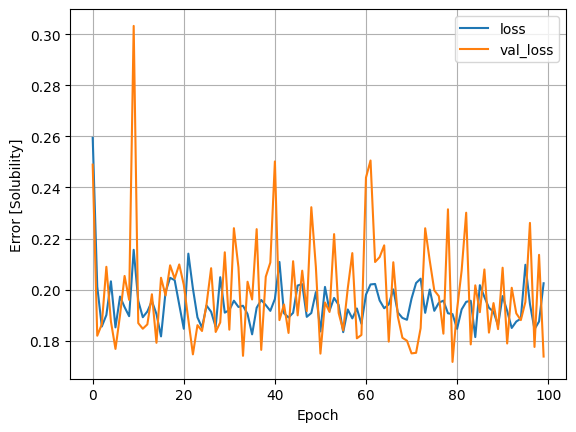

In [ ]:
plot_loss(history)

In [ ]:
linear_model.save('../models/models_Linear')

INFO:tensorflow:Assets written to: ../models/models_Linear/assets


In [ ]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [ ]:
test_results

{'linear_model': [0.17390884459018707,
  0.045300863683223724,
  0.2128399908542633]}

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8ea8948f-b978-492f-a6dd-8ac5feb4b472' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>